# Life Span Analysis
Explore effect of ecological and constituional factors on life span.

sleep hours: ['slowWaveSleep', 'dreamSleep', 'sleep']

weights: ['body', 'brain']

gestation days: ['gestation']

danger levels: ['predation', 'sleepExposure', 'danger']


In [1]:
import pandas as pd
import numpy as np
import os
from time import time

%matplotlib inline
import matplotlib.pyplot as plt # to show images
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import pandas as pd
import io
import requests
import numpy as np

from sklearn.decomposition import PCA # for PCA calculation
from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

mpl_toolkits.mplot3d.axes3d.Axes3D

### Feature Scaling
ref: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler


In [2]:
# feature scaling
from sklearn.preprocessing import StandardScaler
def std_scaler(X):
    scaler = StandardScaler().fit(X)
    return scaler.transform(X)

### Load Data

In [3]:
### load data ###
def load_data(path="./data/sleep_original.csv", fill_nan=-999.00, keep_attr=['life', 'predation', 'sleepExposure', 'danger'], filter_nan=False, filter_list=[], print_info=False):
    '''
        path: local directory of original data file
        fill_nan: replace NaN with specified number
        filter_nan: filter out data with NaN values
    '''
    
    # load data
    path = "./data/sleep_original.csv"
    if os.path.isfile(path):
        csv_file = pd.read_csv(path, usecols = keep_attr)
    else:
        url = "https://yao-lab.github.io/data/sleep1.csv" # Load original data
        src = requests.get(url).content
        csv_file = pd.read_csv(io.StringIO(src.decode('utf-8')),usecols = keep_attr)
    
    if filter_nan:
        if len(filter_list) == 0:
            filter_list = np.array(csv_file.columns)
        idx = set()
        for x in filter_list:
            if len(idx) == 0:
                idx = csv_file[x].isna()
            else:
                idx = idx | (csv_file[x].isna())
        idx = list(map(lambda x: not x, idx))
        csv_file = csv_file[idx]
    else:
        csv_file = csv_file.fillna(fill_nan) # Replace NaN with -999.00 (regarded as infinitely negative)
    
    if print_info:
        print("csv file size: ", csv_file.shape)
    
    # Extra data with attributes (dimensions), specials, and numeric data
    csv_file = csv_file[keep_attr]
    data = np.array(csv_file)[:, 1:]
    attrs = np.array(csv_file.columns[1:])
    species = np.array(csv_file)[:, 0]

    if print_info:
        print("%d Attributes: " %len(attrs))
        print(attrs)
        print("%d Species: " %len(species))
        print(species)
        print("Data shape: ", data.shape) #get data size
    #     print(data[:5])
        print()
    
    data = std_scaler(data)
    return attrs, species, data

### Display data in original 3 dimensions

In [4]:
def show_3d_data(keep_attr=['life', 'predation', 'sleepExposure', 'danger'], scale=100, factor_desc="Danger Factors", label_desc="Life Span"):
    '''
        Display a 3D plot of given label and attributes
        keep_attr[0]: label (numberic data)
        keep_attr[1:]: attributes
    '''
    attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=keep_attr)

    fig = plt.figure(1, figsize=(10, 10))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=134)
    plt.cla()

    for i in range(len(filtered_species)):
        ax.text3D(filtered_data[i, 0],
                  filtered_data[i, 1],
                  filtered_data[i, 2], filtered_species[i],
                  horizontalalignment='center')
        
    # Reorder the labels to have sizes matching the label numbers
    ax.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], s=filtered_species.astype(np.float)*scale,
               edgecolor='k')

    ax.set_title('%s vs %s (Original Data, %d Mammals)'%(factor_desc, label_desc, len(filtered_species)))
    ax.set_xlabel(keep_attr[1])
    ax.set_ylabel(keep_attr[2])
    ax.set_zlabel(keep_attr[3])

    plt.show()

### PCA

In [5]:
def _PCA(attris, species, data, n_components=2):    
    t0 = time()
    # get PCA
    pca = PCA(n_components=n_components, svd_solver='arpack')
    pca.fit(data)
    X_reduction = pca.transform(data)
    t1 = time()
    
    print("explained_variance_ratio: ")
    print(pca.explained_variance_ratio_) 

    # Plot PCA variance_ratio chart
#     plt.plot(pca.explained_variance_ratio_, "o", linewidth=2)
#     plt.axis('tight')
#     plt.xlabel('n_components')
#     plt.ylabel('explained_variance_ratio_')
#     plt.show()

    return X_reduction, t1-t0

#### PCA: Scatter data in reduced 2D dimensional space with details

In [6]:
def show_2d_data_pca(keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep', 'body', 'brain', 'gestation', 'predation', 'sleepExposure', 'danger'], scale=100, factor_desc="All Factors", label_desc="Life Span"):

    attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=keep_attr)
    X_filter, _ = _PCA(attrs, filtered_species, filtered_data)

    plt.figure(figsize=(12,10))

    total_w = filtered_species.astype(np.float)
    color = total_w / np.linalg.norm(total_w)

    plt.scatter(X_filter[:, 0], X_filter[:, 1], alpha=0.5,  s=filtered_species.astype(float)*scale,  c=color, cmap='RdPu')
    cbar = plt.colorbar()
    cbar.set_label('Normalized Life-span Intensity')

    for i in range(len(filtered_species)):
        plt.annotate(filtered_species[i], (X_filter[i, 0]+0.1, X_filter[i, 1]+0.1))

    plt.title('PCA: %s vs %s (Original Data, %d Mammals)'%(factor_desc, label_desc, len(filtered_species)))
    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.show()

#### PCA: Scatter data in reduced 3D dimensional space with details

In [7]:
def show_3d_data_pca(keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep', 'body', 'brain', 'gestation', 'predation', 'sleepExposure', 'danger'], scale=100, factor_desc="All Factors", label_desc="Life Span"):
    
    attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=keep_attr)
    X_filter, _ = _PCA(attrs, filtered_species, filtered_data, n_components=3)

    total_w = filtered_species.astype(np.float)
    color = total_w / np.linalg.norm(total_w)

    fig = plt.figure(1, figsize=(12, 10))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=140)
    plt.cla()

    for i in range(len(filtered_species)):
        ax.text3D(X_filter[i, 0],
                  X_filter[i, 1],
                  X_filter[i, 2], filtered_species[i],
                  horizontalalignment='center')

    # Reorder the labels to have sizes matching the label numbers
    p = ax.scatter(X_filter[:, 0], X_filter[:, 1], X_filter[:, 2], s=filtered_species.astype(np.float)*scale,
               c=color, cmap='RdPu',
               edgecolor='k')
    cbar = plt.colorbar(p)
    cbar.set_label('Normalized Sleep Hour Intensity')

    ax.set_title('PCA: %s vs %s (Original Data, %d Mammals)'%(factor_desc, label_desc, len(filtered_species)))
    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')

    plt.show()

### PCA & Manifold Learning Display

In [8]:
def _pca_manifold(attrs, filtered_species, filtered_data, factor_desc="Danger Factors", label_desc="Life Span"):
    
    sleep_w = filtered_species.astype(np.float)
    color = sleep_w / np.linalg.norm(sleep_w)

    n_points = len(filtered_species)
    n_neighbors = 10
    n_components = 2
    
    # PCA
    Y, elapsed = _PCA(attrs, filtered_species, filtered_data, n_components=n_components)

    fig = plt.figure(figsize=(18, 8))
    plt.suptitle("PCA & Manifold Learning with %i points, %i neighbors, %s vs %s"
                 % (n_points, n_neighbors, factor_desc, label_desc), fontsize=14)
    print("PCA: %.2g sec" % (elapsed))
    ax = fig.add_subplot(256)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
    plt.title("PCA (%.2g sec)" % (elapsed))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
    # original data space
    ax = fig.add_subplot(251, projection='3d')
    p = ax.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], c=color, cmap='RdPu')
    ax.view_init(4, -72)
    cbar = plt.colorbar(p)
    cbar.set_label('Normalized Sleep Hour Intensity')

    # LLE, LTSA, Hessian LLE, Modified LLE
    methods = ['standard', 'ltsa', 'hessian', 'modified']
    labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

    for i, method in enumerate(methods):
        t0 = time()
        Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                            eigen_solver='auto',
                                            method=method).fit_transform(filtered_data)
        t1 = time()
        print("%s: %.2g sec" % (methods[i], t1 - t0))

        ax = fig.add_subplot(252 + i)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')
    
    # ISOMAP
    t0 = time()
    Y = manifold.Isomap(n_neighbors, n_components).fit_transform(filtered_data)
    t1 = time()
    print("Isomap: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(257)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
    plt.title("Isomap (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    # MDS
    t0 = time()
    mds = manifold.MDS(n_components, max_iter=100, n_init=1)
    Y = mds.fit_transform(filtered_data)
    t1 = time()
    print("MDS: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(258)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
    plt.title("MDS (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')


    # SpetralEmbedding
    t0 = time()
    se = manifold.SpectralEmbedding(n_components=n_components,
                                    n_neighbors=n_neighbors)
    Y = se.fit_transform(filtered_data)
    t1 = time()
    print("SpectralEmbedding: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(259)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
    plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    
    # t-SNE
    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
    Y = tsne.fit_transform(filtered_data)
    t1 = time()
    print("t-SNE: %.2g sec" % (t1 - t0))
    ax = fig.add_subplot(2, 5, 10)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap='RdPu')
    plt.title("t-SNE (%.2g sec)" % (t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    plt.show()

## 1. Danger Factors vs Life Span

Factors/ Features: ['predation' 'sleepExposure' 'danger']
 
Label: 'life'

#### Scatter data in original dimensions
Bubble sizes indicate the relative length of sleep hours

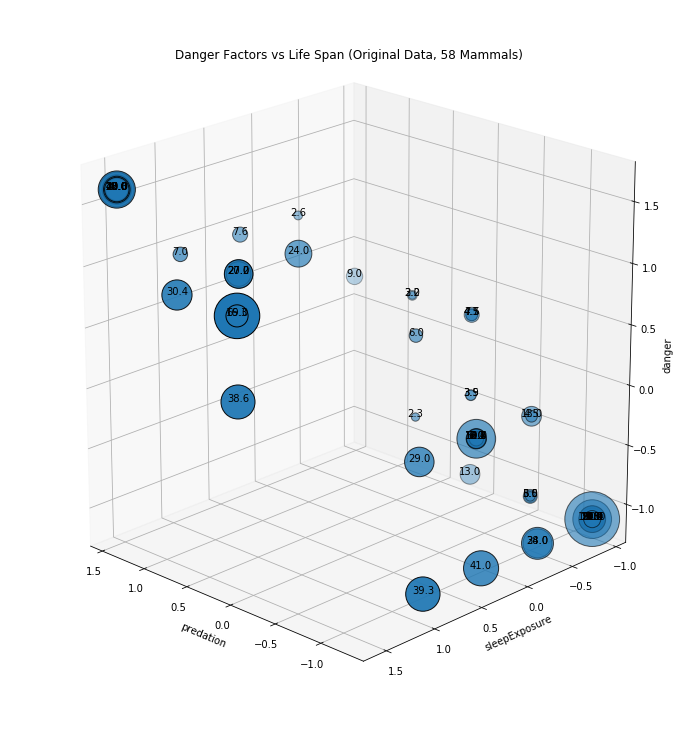

In [9]:
show_3d_data(keep_attr=['life', 'predation', 'sleepExposure', 'danger'], scale=30, factor_desc='Danger Factors', label_desc='Life Span')

#### Scatter data in reduced 2D dimensional space

explained_variance_ratio: 
[0.85993418 0.12623232]
PCA: 0 sec
standard: 0.0091 sec
ltsa: 0.01 sec
hessian: 0.016 sec
modified: 0.014 sec
Isomap: 0.009 sec
MDS: 0.006 sec
SpectralEmbedding: 0.004 sec
t-SNE: 0.19 sec


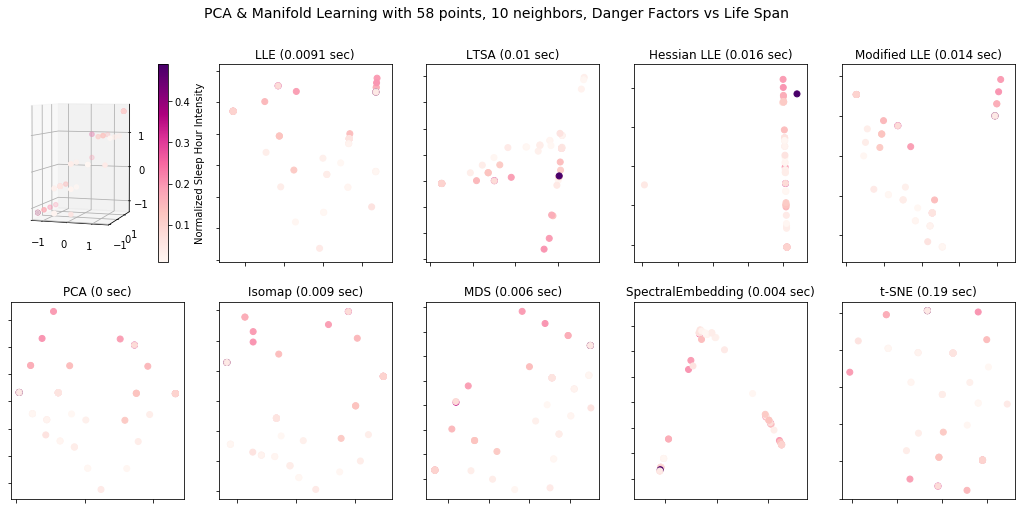

In [10]:
# Danger factors are correlated to dreamSleep
attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=['life', 'predation', 'sleepExposure', 'danger'])
_pca_manifold(attrs, filtered_species, filtered_data, factor_desc="Danger Factors", label_desc="Life Span")

#### PCA: Scatter data in reduced 2D dimensional space with details

explained_variance_ratio: 
[0.85993418 0.12623232]


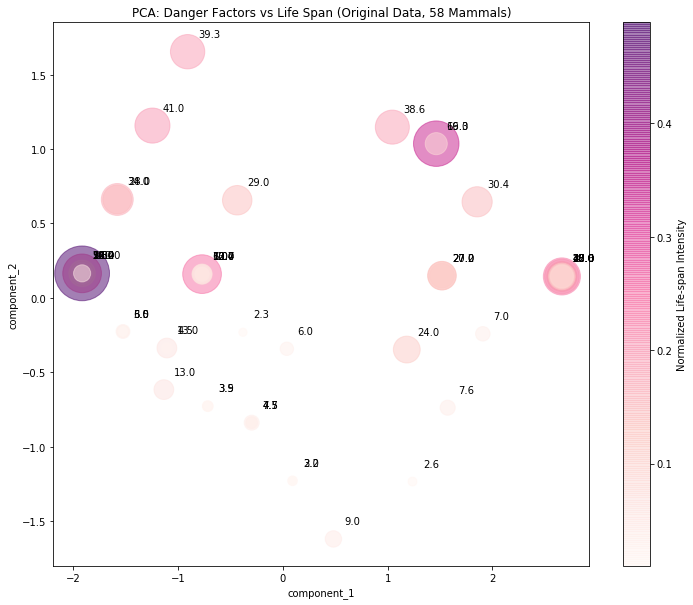

In [11]:
# Danger factors are correlated to dreamSleep
show_2d_data_pca(keep_attr=['life', 'predation', 'sleepExposure', 'danger'], scale=30, factor_desc="Danger Factors", label_desc="Life Span")

comment: danger factors to some extend relate to life span

## 2. Size Factors vs Life Span

Dimensions: ['body', 'brain', 'gestation']
 
Label: 'life'

#### Scatter data in original dimensions
Bubble sizes indicate the relative length of sleep hours

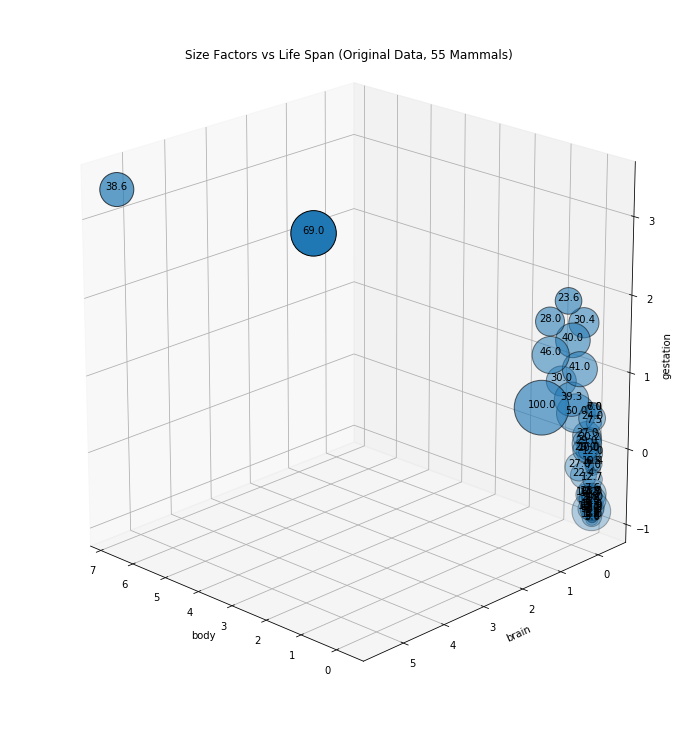

In [12]:
show_3d_data(keep_attr=['life', 'body', 'brain', 'gestation'], scale=30, factor_desc='Size Factors', label_desc='Life Span')

#### Scatter data in reduced 2D dimensional space

explained_variance_ratio: 
[0.85422071 0.12735963]
PCA: 0.001 sec
standard: 0.0094 sec
ltsa: 0.01 sec
hessian: 0.015 sec
modified: 0.013 sec
Isomap: 0.003 sec
MDS: 0.011 sec
SpectralEmbedding: 0.004 sec
t-SNE: 0.2 sec


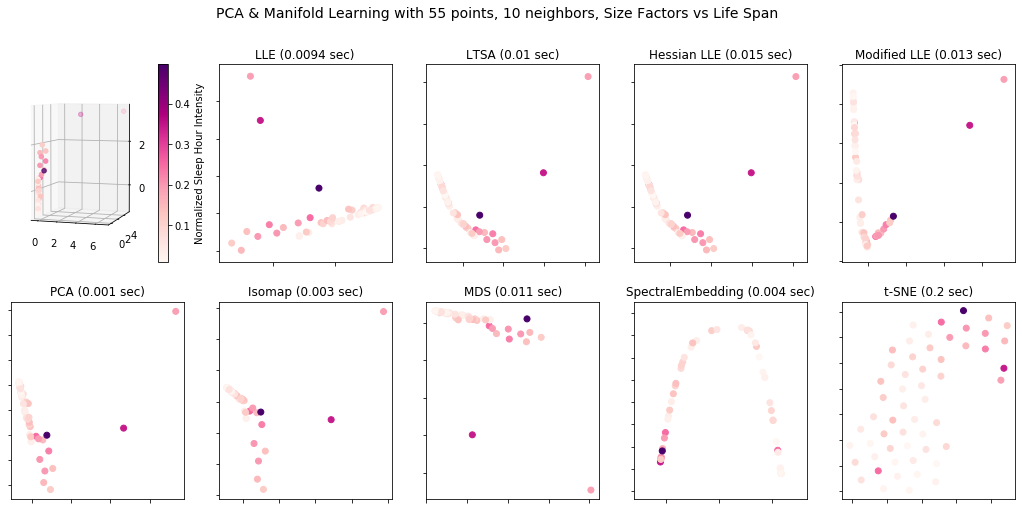

In [13]:
attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=['life', 'body', 'brain', 'gestation'])
_pca_manifold(attrs, filtered_species, filtered_data, factor_desc="Size Factors", label_desc="Life Span")

comment: size factors relate to life span; there are some outliers

#### PCA: Scatter data in reduced 2D dimensional space with details

explained_variance_ratio: 
[0.85422071 0.12735963]


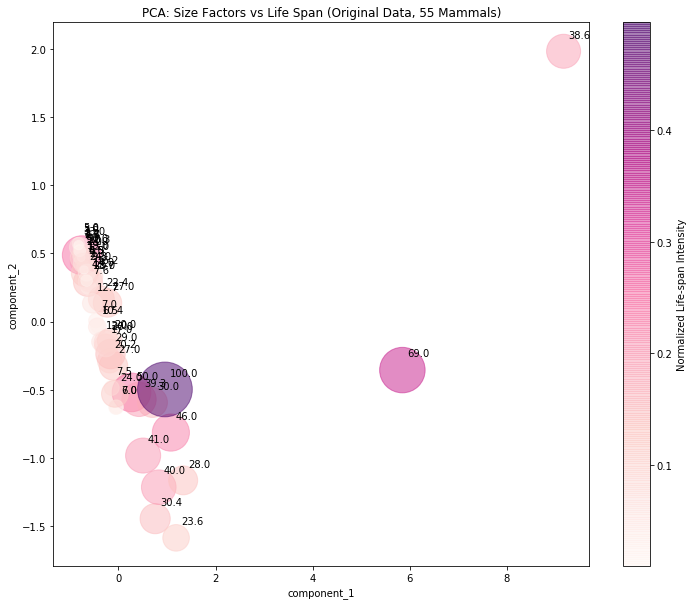

In [14]:
show_2d_data_pca(keep_attr=['life', 'body', 'brain', 'gestation'], scale=30, factor_desc="Size Factors", label_desc="Life Span")

## 3. Sleep Factors vs Life Span

Dimensions: ['slowWaveSleep', 'dreamSleep', 'sleep']
 
Label: 'life'

#### Scatter data in original dimensions
Bubble sizes indicate the relative length of sleep hours

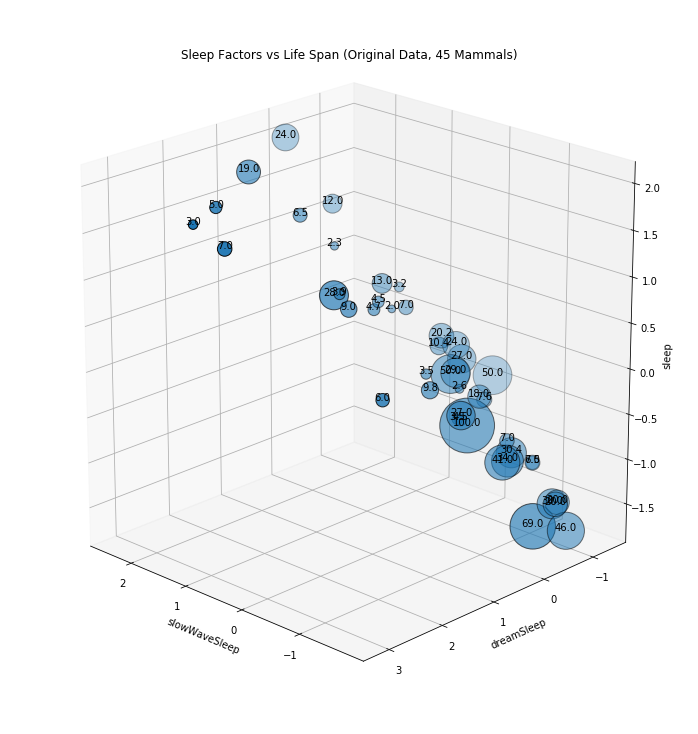

In [15]:
show_3d_data(keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep'], scale=30, factor_desc='Sleep Factors', label_desc='Life Span')

#### Scatter data in reduced 2D dimensional space

explained_variance_ratio: 
[0.83125356 0.16874644]
PCA: 0.001 sec
standard: 0.0073 sec
ltsa: 0.008 sec
hessian: 0.012 sec
modified: 0.01 sec
Isomap: 0.003 sec
MDS: 0.005 sec
SpectralEmbedding: 0.003 sec
t-SNE: 0.17 sec


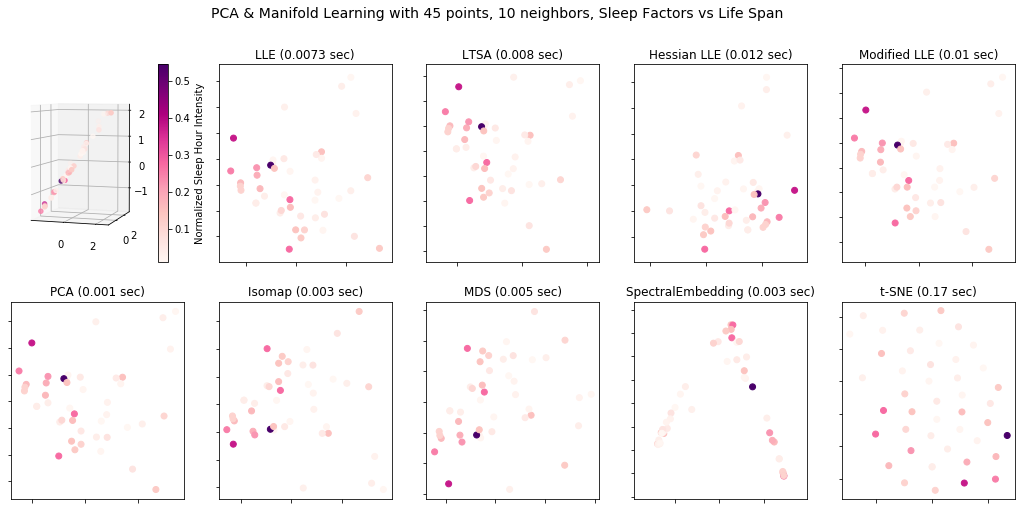

In [16]:
attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep'])
_pca_manifold(attrs, filtered_species, filtered_data, factor_desc="Sleep Factors", label_desc="Life Span")

comment: sleep factors relate to life span; there are some outliers

#### PCA: Scatter data in reduced 2D dimensional space with details

explained_variance_ratio: 
[0.83125356 0.16874644]


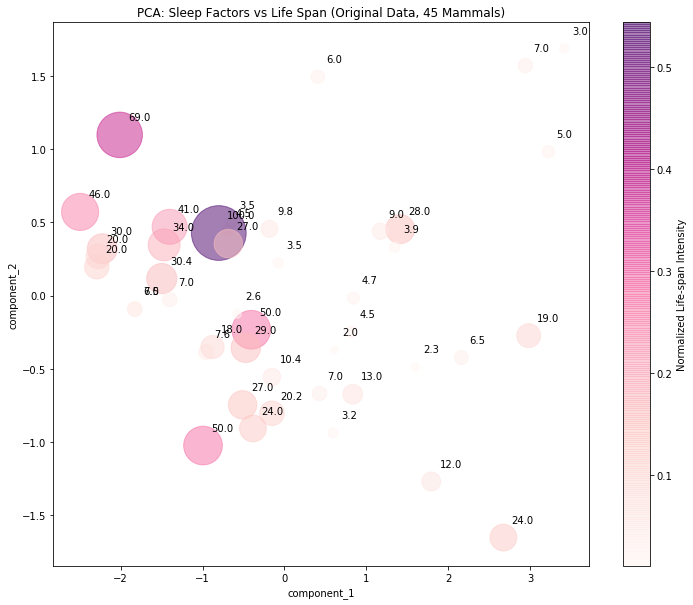

In [17]:
show_2d_data_pca(keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep'], scale=30, factor_desc="Sleep Factors", label_desc="Life Span")

## 4. All Factors vs Life Span

Dimensions: ['slowWaveSleep', 'dreamSleep', 'sleep', 'body', 'brain', 'gestation', 'predation', 'sleepExposure', 'danger']

Label: ['life']

#### Scatter data in reduced 2D dimensional space

explained_variance_ratio: 
[0.54043125 0.23200619]
PCA: 0 sec
standard: 0.0069 sec
ltsa: 0.009 sec
hessian: 0.012 sec
modified: 0.011 sec
Isomap: 0.0037 sec
MDS: 0.012 sec
SpectralEmbedding: 0.005 sec
t-SNE: 0.16 sec


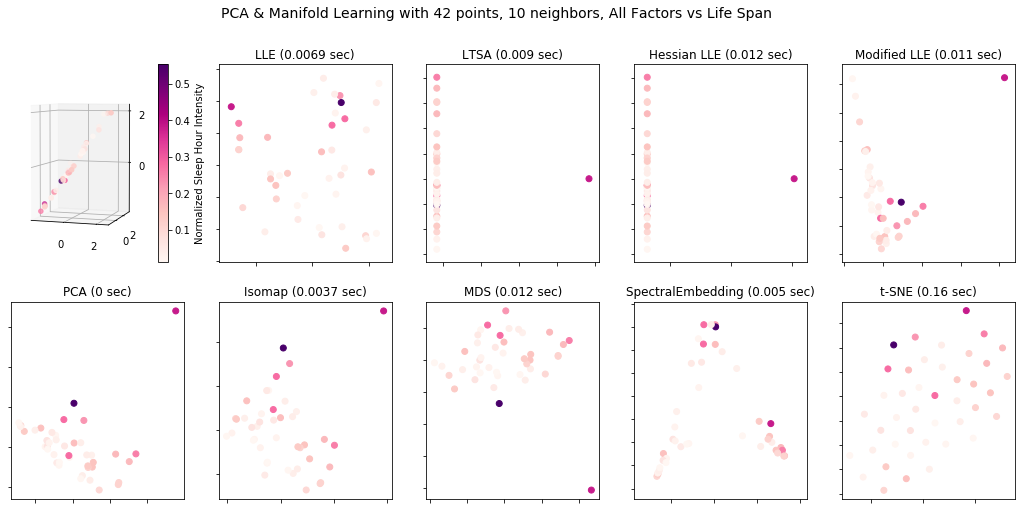

In [18]:
attrs, filtered_species, filtered_data = load_data(filter_nan=True, keep_attr=['life','slowWaveSleep', 'dreamSleep', 'sleep', 'body', 'brain', 'gestation', 'predation', 'sleepExposure', 'danger'])
_pca_manifold(attrs, filtered_species, filtered_data, factor_desc="All Factors", label_desc="Life Span")

Comments: All factors have relation to life span.

#### PCA: Scatter data in reduced 3D dimensional space with details

explained_variance_ratio: 
[0.54043125 0.23200619 0.11399284]


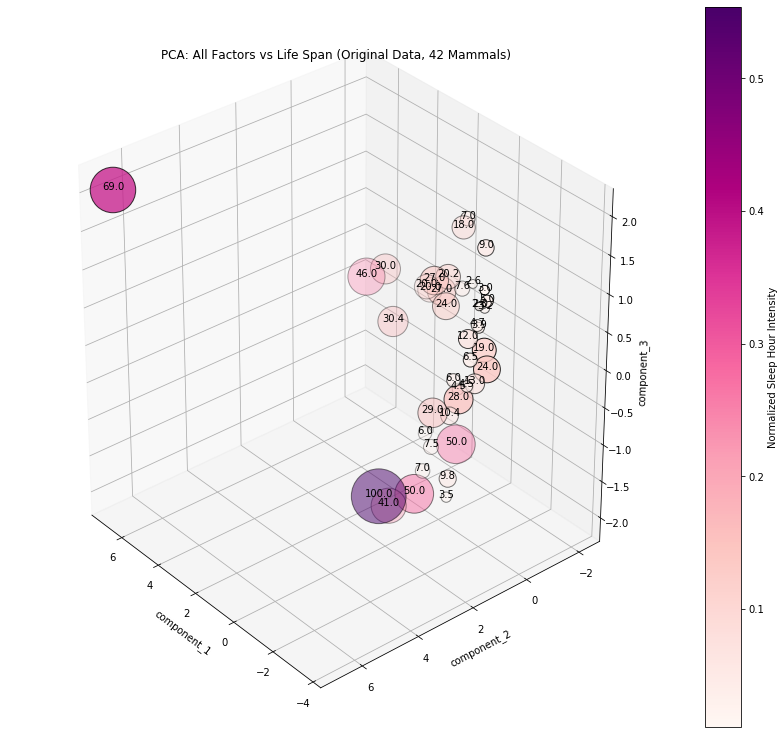

In [19]:
show_3d_data_pca(keep_attr=['life', 'slowWaveSleep', 'dreamSleep', 'sleep', 'body', 'brain', 'gestation', 'predation', 'sleepExposure', 'danger'], scale=30, factor_desc="All Factors", label_desc="Life Span")